<center><h1>Get Data on NHS Waiting Times</h1></center>

In [1]:
import nhsdata
import numpy as np
import importlib
#importlib.reload(nhsdata)

### Get urls of all pages with the data

In [2]:
page_names = nhsdata.getAnEpages(verbose = 10)

Total of 13 pages found


### Get all xls file names

In [3]:
xls_file_names = nhsdata.get_xls_files(page_names, verbose = 10)

Total of 357 xls files found.


### Remove unwanted files

In [4]:
data = nhsdata.check_files(xls_file_names, verbose = 10)

Found 300 data sets.


### Get all Trust names

In [5]:
allNames = nhsdata.get_all_names(data[0], verbose = 0)

### Collect data from xls files

In [6]:
importlib.reload(nhsdata)
attendences, over4hours, periods = nhsdata.collectData(data, allNames, verbose = 0)


### Turn weekly data into monthly data

In [7]:
final_attendence, final_periods = nhsdata.sort_data(allNames, attendences, periods)
final_over4hours, final_periods = nhsdata.sort_data(allNames, over4hours, periods)
months = nhsdata.get_numpy_dates(final_periods)

### Final data tidy

- Turn all numbers as strings into ints
- Get rid of the nan line

In [8]:
final_attendence2 = nhsdata.tidy_data(final_attendence)
final_over4hours2 = nhsdata.tidy_data(final_over4hours)

### Save data

In [9]:
np.save("NHSwaiting.npy", [allNames, final_periods, final_attendence2, final_over4hours2])

C:\Users\David\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


## Check Plot

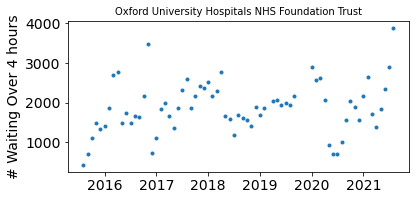

In [10]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=14)

i = 173

fig = matplotlib.pyplot.figure(figsize=(6,3))

ax1 = fig.add_subplot(111)
plt.title(allNames[i],size = 10)
mask = (final_over4hours[i,:] != '-')
waiting = final_over4hours[i,:][mask]
ax1.plot(months[mask], waiting,'.', lw=3)
ax1.set_ylabel("# Waiting Over 4 hours")
plt.tight_layout()
plt.show()

In [11]:
waiting = final_over4hours[0,:]

print("--Waiting--")
print("total diff: {}, => {:.4} %".format(waiting[0] - waiting[-1], 100*(waiting[0] - waiting[-1])/waiting[-1]))

att = final_attendence[0,:]
print("--Attendence--")
print("*max* total diff: {}, => {:.4} %".format(max(att) - att[-1], 100*(max(att) - att[-1])/att[-1]))

--Waiting--
total diff: 620659, => 1.321e+03 %
--Attendence--
*max* total diff: 614463, => 37.23 %


In [12]:
np.where(allNames == "Portsmouth Hospitals University National Health Service Trust")

(array([175], dtype=int64),)